Enter total investment amount (₹):  100000
Enter start date (YYYY-MM-DD) between 2025-07-31 and 2025-08-14:  2025-08-7
Enter end date (YYYY-MM-DD) between 2025-08-07 and 2025-08-14:  2025-08-07



2 Failed downloads:
['KALYANJEW.NS', 'LTIMINDTREE.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=30d) (Yahoo error = "No data found, symbol may be delisted")')


Valid stocks for trading: ['TCS.NS', 'INFY.NS', 'HCLTECH.NS', 'TECHM.NS', 'WIPRO.NS', 'MPHASIS.NS', 'PERSISTENT.NS', 'COFORGE.NS', 'LTTS.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'SBIN.NS', 'INDUSINDBK.NS', 'BANDHANBNK.NS', 'PNB.NS', 'IDFCFIRSTB.NS', 'FEDERALBNK.NS', 'SUNPHARMA.NS', 'CIPLA.NS', 'DRREDDY.NS', 'DIVISLAB.NS', 'AUROPHARMA.NS', 'LUPIN.NS', 'ZYDUSLIFE.NS', 'GLENMARK.NS', 'BIOCON.NS', 'ALKEM.NS', 'TATAMOTORS.NS', 'M&M.NS', 'MARUTI.NS', 'EICHERMOT.NS', 'BAJAJ-AUTO.NS', 'TVSMOTOR.NS', 'ASHOKLEY.NS', 'HEROMOTOCO.NS', 'BOSCHLTD.NS', 'HINDUNILVR.NS', 'ITC.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'MARICO.NS', 'DABUR.NS', 'GODREJCP.NS', 'COLPAL.NS', 'TATACONSUM.NS', 'IOC.NS', 'BPCL.NS', 'ONGC.NS', 'GAIL.NS', 'RELIANCE.NS', 'TANLA.NS']

--- Investing on 2025-08-07 ---

Time: 2025-08-07 09:15:00+05:30
Pair: DIVISLAB.NS/BPCL.NS | Type: LONG | Shares: 16.41/319.23 | Entry: 6093.00/313.25 | Current Price: 6093.00/313.25
Pair: BRITANNIA.NS/GODREJCP.NS | Type: LONG | S

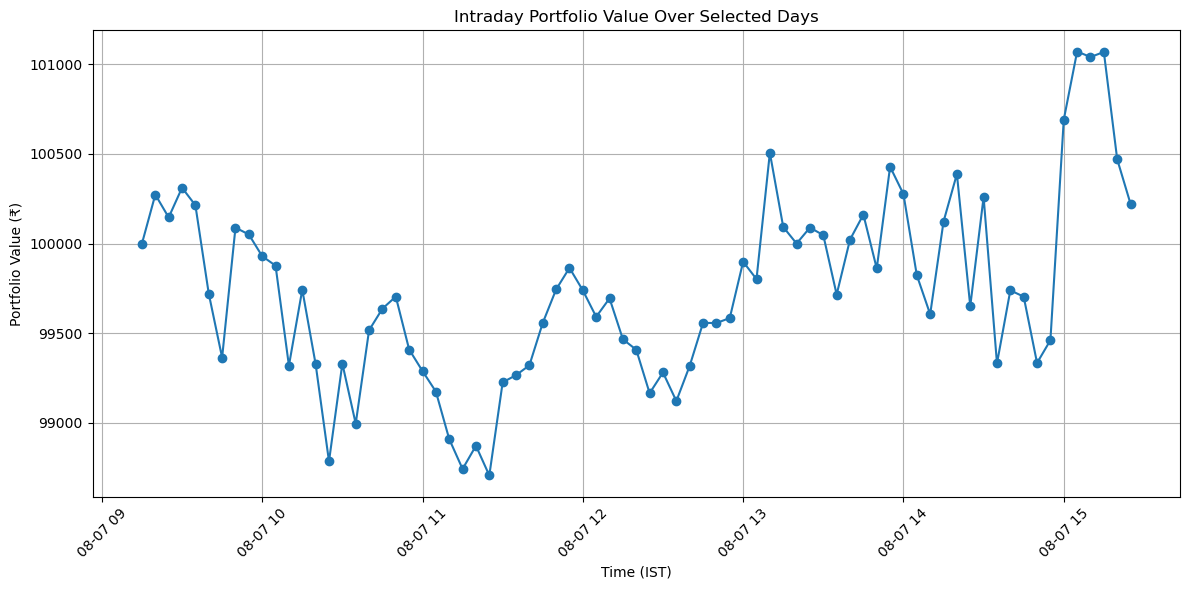

In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz

# --- Stocks list ---
it_sector = ['TCS.NS', 'INFY.NS', 'HCLTECH.NS', 'TECHM.NS', 'WIPRO.NS',
             'LTIMINDTREE.NS', 'MPHASIS.NS', 'PERSISTENT.NS', 'COFORGE.NS', 'LTTS.NS']
banking_sector = ['HDFCBANK.NS','ICICIBANK.NS','KOTAKBANK.NS','AXISBANK.NS','SBIN.NS',
                  'INDUSINDBK.NS','BANDHANBNK.NS','PNB.NS','IDFCFIRSTB.NS','FEDERALBNK.NS']
pharma_sector = ['SUNPHARMA.NS','CIPLA.NS','DRREDDY.NS','DIVISLAB.NS','AUROPHARMA.NS',
                 'LUPIN.NS','ZYDUSLIFE.NS','GLENMARK.NS','BIOCON.NS','ALKEM.NS']
auto_sector = ['TATAMOTORS.NS','M&M.NS','MARUTI.NS','EICHERMOT.NS','BAJAJ-AUTO.NS',
               'TVSMOTOR.NS','ASHOKLEY.NS','HEROMOTOCO.NS','BOSCHLTD.NS','ESCORTS.NS']
fmcg_sector = ['HINDUNILVR.NS','ITC.NS','NESTLEIND.NS','BRITANNIA.NS','MARICO.NS',
               'DABUR.NS','GODREJCP.NS','COLPAL.NS','TATACONSUM.NS','UBL.NS']
oil_sector = ['IOC.NS','BPCL.NS','ONGC.NS','GAIL.NS','RELIANCE.NS']
jewelry_sector = ['TANLA.NS', 'KALYANJEW.NS']

all_stocks = it_sector + banking_sector + pharma_sector + auto_sector + fmcg_sector + oil_sector + jewelry_sector

# --- Parameters ---
transaction_cost_rate = 0.0005
interval = '5m'
min_corr_threshold = 0.7
max_coint_pvalue = 0.15
ewm_span = 20
z_enter = 2
z_exit = 0.5
stop_loss_pct = 0.02

# --- Helper Functions ---
def download_intraday_data(tickers, period='30d', interval='5m'):
    print(f"Downloading last {period} intraday data...")
    data = yf.download(tickers, period=period, interval=interval, group_by='ticker',
                       auto_adjust=True, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        close_df = pd.DataFrame()
        for ticker in tickers:
            if ticker in data.columns.levels[0]:
                close_df[ticker] = data[ticker]['Close']
    else:
        close_df = data['Close'].to_frame()
    # Convert to IST
    close_df.index = close_df.index.tz_convert('Asia/Kolkata')
    return close_df

def calc_ewm_corr(df, span=ewm_span):
    returns = df.pct_change().dropna()
    if returns.empty:
        return pd.DataFrame(np.nan, index=df.columns, columns=df.columns)
    cov = returns.ewm(span=span).cov()
    var = returns.ewm(span=span).var()
    last_timestamp = returns.index[-1]
    cov_last = cov.xs(last_timestamp)
    var_last = var.xs(last_timestamp)
    stocks = df.columns
    corr_matrix = pd.DataFrame(index=stocks, columns=stocks, dtype=float)
    for s1 in stocks:
        for s2 in stocks:
            try:
                c = cov_last.loc[s1, s2]
                v1 = var_last.loc[s1]
                v2 = var_last.loc[s2]
                corr_matrix.loc[s1, s2] = c / (np.sqrt(v1)*np.sqrt(v2)) if v1 > 0 and v2 > 0 else np.nan
            except:
                corr_matrix.loc[s1, s2] = np.nan
    return corr_matrix

def zscore(series):
    return (series - series.mean()) / series.std()

# --- User Input ---
investment_amount = float(input("Enter total investment amount (₹): "))
today = datetime.now(pytz.timezone('Asia/Kolkata')).date()
max_start_date = today - timedelta(days=1)
min_start_date = max_start_date - timedelta(days=14)

while True:
    start_date_str = input(f"Enter start date (YYYY-MM-DD) between {min_start_date} and {max_start_date}: ")
    try:
        start_date = datetime.strptime(start_date_str, '%Y-%m-%d').date()
        if start_date < min_start_date or start_date > max_start_date:
            raise ValueError
        break
    except:
        print("Invalid date. Try again.")

while True:
    end_date_str = input(f"Enter end date (YYYY-MM-DD) between {start_date} and {max_start_date}: ")
    try:
        end_date = datetime.strptime(end_date_str, '%Y-%m-%d').date()
        if end_date < start_date or end_date > max_start_date:
            raise ValueError
        break
    except:
        print("Invalid date. Try again.")

# --- Download 30-day data once ---
intraday_data = download_intraday_data(all_stocks, period='30d', interval=interval)
intraday_data = intraday_data.dropna(axis=1, how='any')
valid_stocks = intraday_data.columns.tolist()
print(f"Valid stocks for trading: {valid_stocks}")

# --- Simulation Loop ---
current_investment = investment_amount
all_time_points = []
all_equity = []

# Precompute the past 30 days only once
past_30_days_data = intraday_data[intraday_data.index.date < start_date]
accumulated_data = past_30_days_data[valid_stocks].copy()

date_range = pd.date_range(start=start_date, end=end_date)
for invest_day in date_range:
    day_data = intraday_data[intraday_data.index.date == invest_day.date()]
    if day_data.empty:
        print(f"{invest_day.date()} Market was closed. Skipping.")
        continue
    print(f"\n--- Investing on {invest_day.date()} ---")
    cash = current_investment
    positions = {}
    equity_curve = []
    time_points = []

    # Append current day data to accumulated data
    accumulated_data = pd.concat([accumulated_data, day_data[valid_stocks]])

    for current_time in day_data.index:
        current_intraday_slice = accumulated_data.loc[accumulated_data.index <= current_time]
        corr_matrix = calc_ewm_corr(current_intraday_slice)
        # Identify pairs
        pairs = []
        stocks = current_intraday_slice.columns.tolist()
        for i in range(len(stocks)):
            for j in range(i+1, len(stocks)):
                s1, s2 = stocks[i], stocks[j]
                c = corr_matrix.loc[s1, s2]
                if pd.notna(c) and c > min_corr_threshold:
                    pairs.append((s1, s2, c))
        # Cointegration
        coint_pairs = []
        for s1, s2, c in pairs:
            try:
                p_val = coint(current_intraday_slice[s1], current_intraday_slice[s2])[1]
                if p_val < max_coint_pvalue:
                    coint_pairs.append((s1, s2, c, p_val))
            except:
                pass
        # Trading logic
        for s1, s2, corr_val, p_val in coint_pairs:
            try:
                X = sm.add_constant(current_intraday_slice[s2])
                model = sm.OLS(current_intraday_slice[s1], X).fit()
                beta = model.params[s2]
            except:
                continue
            spread = current_intraday_slice[s1] - beta * current_intraday_slice[s2]
            spread_mean = spread.mean()
            spread_std = spread.std()
            if spread_std == 0 or np.isnan(spread_std):
                continue
            current_spread = current_intraday_slice.at[current_time, s1] - beta * current_intraday_slice.at[current_time, s2]
            z = (current_spread - spread_mean)/spread_std
            pair = (s1, s2)
            pos = positions.get(pair, {'position':0})
            price1 = current_intraday_slice.at[current_time, s1]
            price2 = current_intraday_slice.at[current_time, s2]

            # Entry
            if pos['position'] == 0:
                if z > z_enter:
                    positions[pair] = {'position':-1,'shares_s1':cash/price1,'shares_s2':cash/price2,
                                       'entry_price1':price1,'entry_price2':price2}
                elif z < -z_enter:
                    positions[pair] = {'position':1,'shares_s1':cash/price1,'shares_s2':cash/price2,
                                       'entry_price1':price1,'entry_price2':price2}
            # Exit
            else:
                if abs(z) < z_exit:
                    positions.pop(pair)
        # Update equity
        holdings_value = 0
        for pair, pos in positions.items():
            s1, s2 = pair
            price1 = current_intraday_slice.at[current_time, s1]
            price2 = current_intraday_slice.at[current_time, s2]
            if pos['position'] == 1:
                val = pos['shares_s1']*price1 - pos['shares_s2']*price2
            elif pos['position'] == -1:
                val = -pos['shares_s1']*price1 + pos['shares_s2']*price2
            else:
                val = 0
            holdings_value += val
        net_worth = cash + holdings_value
                # ---- Debug Portfolio Snapshot ----
        print(f"\nTime: {current_time}")
        for pair, pos in positions.items():
            s1, s2 = pair
            price1 = current_intraday_slice.at[current_time, s1]
            price2 = current_intraday_slice.at[current_time, s2]
            pos_type = "LONG" if pos['position'] == 1 else "SHORT"
            print(f"Pair: {s1}/{s2} | Type: {pos_type} | Shares: {pos['shares_s1']:.2f}/{pos['shares_s2']:.2f} "
                  f"| Entry: {pos['entry_price1']:.2f}/{pos['entry_price2']:.2f} | "
                  f"Current Price: {price1:.2f}/{price2:.2f}")

        invested_value = holdings_value
        print(f"Cash: ₹{cash:.2f} | Invested: ₹{invested_value:.2f} | Portfolio Value: ₹{net_worth:.2f}")

        time_points.append(current_time)
        equity_curve.append(net_worth)

    # End of day summary
    if equity_curve:
        day_end_value = equity_curve[-1]
        daily_return_pct = (day_end_value - investment_amount)/investment_amount*100
        print(f"End of {invest_day.date()} | Portfolio value: ₹{day_end_value:.2f} | Return: {daily_return_pct:.2f}%")
        all_time_points += time_points
        all_equity += equity_curve
        current_investment = day_end_value  # roll forward

# --- Plot ---
if all_equity:
    equity_df = pd.DataFrame({'equity': all_equity}, index=pd.to_datetime(all_time_points))
    plt.figure(figsize=(12,6))
    plt.plot(equity_df.index, equity_df['equity'], marker='o', linestyle='-')
    plt.xlabel("Time (IST)")
    plt.ylabel("Portfolio Value (₹)")
    plt.title("Intraday Portfolio Value Over Selected Days")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
